In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import os
import math
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
N = 1000 # number of paths to load from path dataset
L = 1000 # fixed length for sin wave training data
T = 20

# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = 'random_paths'
MAP_SHAPE = (64,64)

# training parameters
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

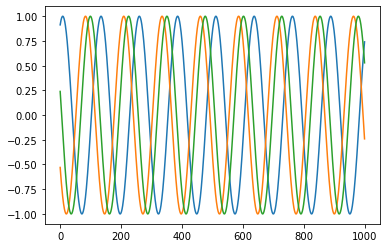

In [3]:
x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1) # want to shift all vlaues of each instance of training data a bit
y = np.sin(x/1.0/T).astype(np.float32) # create corresponding sine values

plt.figure()
plt.plot(y[0])
plt.plot(y[342])
plt.plot(y[832]) # they all are shifted withing +/- 20 of each other

In [4]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        # self.map = np.loadtxt(map_file, skiprows=2).reshape(shape)
        # self.map = self.map[np.newaxis, :, :]
        x = torch.tensor([]) # empty list to hold input series tensors
        path_list = []
        num_paths = 0
        for filename in tqdm(os.listdir(path_dir)):
            num_paths += 1
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_tensor = self.convert_path(shape, self.path)
                
                x = torch.cat((x,self.path_tensor)) # add the path to paths list

                path_list.append(self.path_tensor)
        mu = x.mean(dim=0)
        sig = x.std(dim=0)

        self.sequences = []
        for path in range(len(path_list)):
           self.sequences.append((path_list[path] - mu)/sig)
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        # print(path)
        # print(f'xs: {path[:,0]}')
        # print(f'ys: {path[:,1]}')
        path_tensor = torch.tensor(path)
        # print(path_tensor)
        return path_tensor

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # x = np.float32(self.sequences[idx])
        # x = torch.Tensor(x).to(self.device)

        x = self.sequences[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

        #return image, label

In [5]:
# train_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/{DATASET}/small_2000", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=None, device=device)
# dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [6]:
# print(train_dataset[0])
# print(train_dataset.device)
# print(len(train_dataset))
# print(train_dataset[24].shape)
# print(train_dataset[24])
# # plt.imshow(train_dataset[23].cpu().detach().numpy())

In [7]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden) # input size 1 since we go thorugh one by one
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1) # only predict one value on output layer

    def forward(self, x, future=0): # future prediction optionally allows for prediction of future values
        outputs = []
        # print(f'x shape: {x.shape}')
        # n_samples = x.size(0)
        n_samples = len(x)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial hidden state layer 1
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial cell state layer 1
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial hidden state lastm layer 2
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32) # initial hidden state lastm layer 2

        for input_t in x.split(1, dim=1):   # allows us to look at one element at a time for each item in batch
                                            # split the tensor into chunks, where each chunk is a view of the data
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            # print(f'input_t: {input_t.shape}')
            # print(f'h_t: {h_t}')
            # print(f'c_t: {c_t}')
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i  in range(future): # if we are trying to predict future values (if future is not zero)
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        # concat outputs and put into tensor
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [8]:
# print(y.shape)
# print(y,[0])

In [9]:

# for training + testing we only want to look at the "y values", we don't care about "time step"
train_input = torch.from_numpy(y[3:, :-1]) # start at sample #3, and take values from beginning until last value (Excluded)
train_target = torch.from_numpy(y[3:, 1:]) # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further
# print(train_input)
# print(train_input.shape)
test_input = torch.from_numpy(y[:3, :-1]) # start at sample #3, and take values from beginning until last value (Excluded)
test_target = torch.from_numpy(y[:3, 1:]) # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further


In [20]:
print(train_input.shape)
print(train_target.shape)
print(train_input[2].shape)

torch.Size([997, 999])
torch.Size([997, 999])
torch.Size([999])


In [10]:
# train_input = train_dataset[3:][:][:-1] # start at sample #3, and take values from beginning until last value (Excluded)
# train_target = train_dataset[3:][:][1:] # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further

In [11]:
# test_input = train_dataset[:3][:][:-1] # start at sample #3, and take values from beginning until last value (Excluded)
# test_target = train_dataset[:3][:][1:] # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further

In [12]:

# # for training + testing we only want to look at the "y values", we don't care about "time step"
# train_input = sequences[1:, :-1] # start at sample #3, and take values from beginning until last value (Excluded)
# train_target = sequences[1:, 1:] # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further
# print(train_input)
# print(train_input.shape)
# test_input = sequences[:1, :-1] # start at sample #3, and take values from beginning until last value (Excluded)
# test_target = sequences[:1, 1:] # starts at 1 and goes to end, so we can compare the input to the output which has the value at +1 index further


In [21]:
model = LSTMPredictor()
loss_func = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr = 0.9)

n_steps = 2

def closure():
        optimizer.zero_grad()
        out = model(train_input)
        # print(f'out: {out.shape}')
        # print(f'train_target: {train_target.shape}')
        loss = loss_func(out, train_target)
        print(f'loss: {loss.item()}')
        loss.backward()
        return loss

# training loop
for i in range (n_steps):
    print(f'step: {i}')
    
    optimizer.step(closure)

step: 0
loss: 0.4988757073879242
loss: 0.49586552381515503
loss: 0.21997947990894318
loss: 0.33612334728240967
loss: 0.03970073163509369
loss: 0.029910650104284286
loss: 0.025791281834244728
loss: 0.02487187273800373
loss: 0.022168926894664764
loss: 0.0179209616035223
loss: 0.011681432835757732
loss: 0.006276438944041729
loss: 0.004711080342531204
loss: 0.003915660083293915
loss: 0.0029889822471886873
loss: 0.0024757101200520992
loss: 0.0018408772302791476
loss: 0.0012217100011184812
loss: 0.001034567947499454
loss: 0.001001959783025086
step: 1
loss: 0.00099225586745888
loss: 0.0009526087087579072
loss: 0.000879772356711328
loss: 0.0007615734357386827
loss: 0.000651329115498811
loss: 0.0005081400158815086
loss: 0.0004329255025368184
loss: 0.000361071404768154
loss: 0.0003388274635653943
loss: 0.00031860527815297246
loss: 0.0003085931239183992
loss: 0.00029755631112493575
loss: 0.0002746829413808882
loss: 0.000252107682172209
loss: 0.0002337751939194277
loss: 0.00021728630235884339
loss

In [14]:
# prediction loop
with torch.no_grad():
    future=1000
    pred = model(test_input, future=future)
    # loss = loss_func(pred[:, :-future], test_target)
    # print(f'loss: {loss.item()}')
    y = pred.detach().numpy()

loss: 6.463068530138116e-06


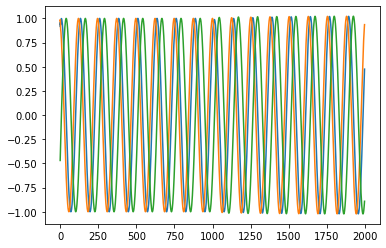

In [15]:
plt.figure()
plt.plot(y[0])
plt.plot(y[1])
plt.plot(y[2])
# plt.plot(y[3])
plt.show()